In [ ]:
# !pip install tensorflow tensorflow-datasets ipywidgets matplotlib

In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

In [ ]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [ ]:
ds = tfds.load('fashion_mnist',split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteCDP2EV/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteCDP2EV/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
ds.as_numpy_iterator().next()['label']

2

<h2>Data Visualization</h2>

In [ ]:
import numpy as np

dataitr = ds.as_numpy_iterator()

In [ ]:
dataitr.next()  # it will give next set of data always

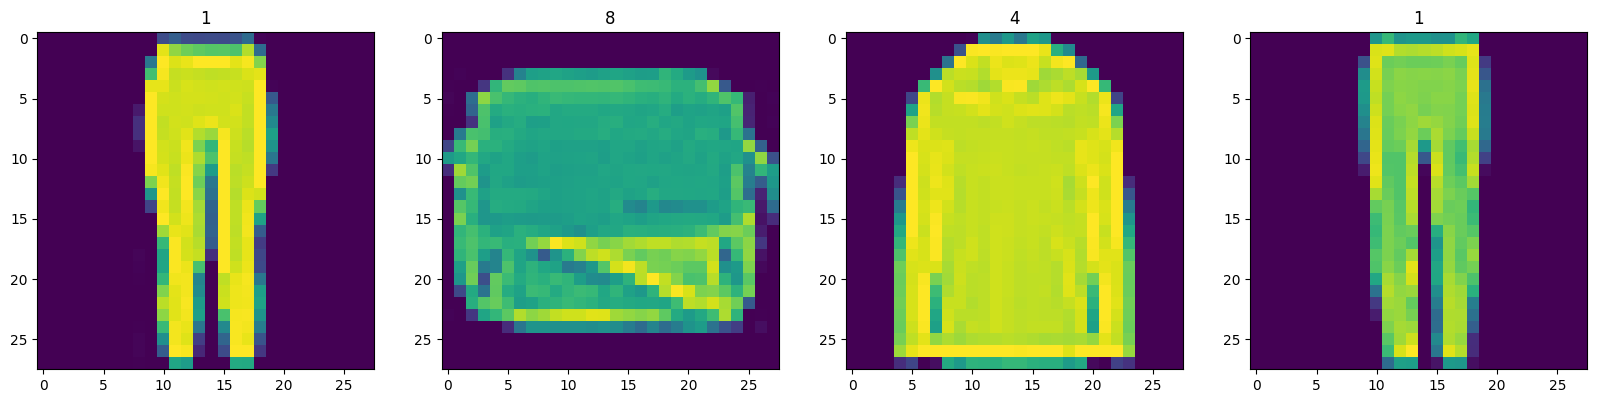

In [ ]:
fig,ax = plt.subplots(ncols = 4, figsize = (20,20))

for idx in range(4):
  sample = dataitr.next()
  ax[idx].imshow(np.squeeze(sample['image']))
  ax[idx].title.set_text(sample['label'])

<h2>Data Preprocessing </h2>

In [ ]:
def scale_images(data):
  img = data['image']
  return img/255

In [ ]:
# Building Pipeline
ds = ds.map(scale_images)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [ ]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

<h2> Build Model </h2>

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Conv2D, Reshape, Dense, LeakyReLU, Dropout, UpSampling2D

Build Generator

In [ ]:
def build_generator():
  model = Sequential()

  model.add(Dense(7*7*128,input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(1,4,padding='same',activation='sigmoid'))

  return model

In [ ]:
generator = build_generator()

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

test generator


In [ ]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 2s 2s/step


In [ ]:
img.shape

(4, 28, 28, 1)

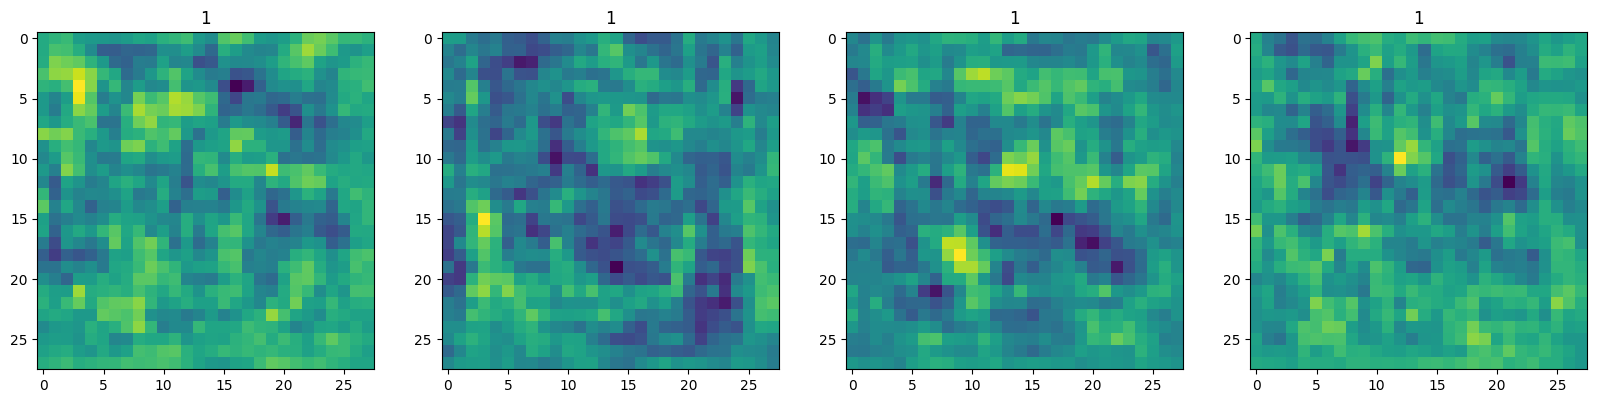

In [ ]:
fig,ax = plt.subplots(ncols = 4, figsize = (20,20))

for idx,img in enumerate(img):
  ax[idx].imshow(np.squeeze(img))
  ax[idx].title.set_text(sample['label'])

Build Discriminator

In [ ]:
def build_discriminator():
  model = Sequential()

  model.add(Conv2D(32,5,input_shape = (28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(64,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(128,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(256,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation = 'sigmoid'))

  return model

In [ ]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [ ]:
img = generator.predict(np.random.randn(4,128,1))
discriminator.predict(img)

1/1 [==============================] - 0s 324ms/step


array([[0.49816757],
       [0.49820238],
       [0.49812847],
       [0.4980523 ]], dtype=float32)

<h2>Construct Training Loops</h2>

In [ ]:
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

We need to run both generator and optimizer at same speed. Hnce we can add some noise to do that. Hence these losses

In [ ]:
gen_opti = Adam(learning_rate = 0.0001)
dis_opti = Adam(learning_rate = 0.00001)

In [ ]:
gen_loss = BinaryCrossentropy()
dis_loss = BinaryCrossentropy()

In [ ]:
from keras.models import Model

class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, gen_opti, dis_opti, gen_loss, dis_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.gen_opti = gen_opti
        self.dis_opti = dis_opti
        self.gen_loss = gen_loss
        self.dis_loss = dis_loss

    def train_step(self, batch):
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss - BINARYCROSS
            total_d_loss = self.dis_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.dis_opti.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.gen_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.gen_opti.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}


Creating instance of the class

In [ ]:
fashGAN = FashionGAN(generator,discriminator)

In [ ]:
# Compile the model
fashGAN.compile(gen_opti,dis_opti,gen_loss,dis_loss)

In [ ]:
import os
from keras.preprocessing.image import array_to_img
from keras.callbacks import Callback

BUild Callback

In [ ]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()

        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

Training

In [ ]:
hist = fashGAN.fit(ds, epochs=10, callbacks=[ModelMonitor()])

Epoch 1/20
469/469 [==============================] - 92s 166ms/step - d_loss: 0.5248 - g_loss: 1.2007
Epoch 2/20
469/469 [==============================] - 77s 164ms/step - d_loss: 0.6843 - g_loss: 0.9657
Epoch 3/20
469/469 [==============================] - 77s 163ms/step - d_loss: 0.6994 - g_loss: 0.6500
Epoch 4/20
469/469 [==============================] - 77s 164ms/step - d_loss: 0.6907 - g_loss: 0.6852
Epoch 5/20
469/469 [==============================] - 77s 164ms/step - d_loss: 0.6908 - g_loss: 0.6804
Epoch 6/20
469/469 [==============================] - 77s 163ms/step - d_loss: 0.6958 - g_loss: 0.6592
Epoch 7/20
469/469 [==============================] - 77s 163ms/step - d_loss: 0.6912 - g_loss: 0.6779
Epoch 8/20
469/469 [==============================] - 77s 163ms/step - d_loss: 0.6932 - g_loss: 0.6698
Epoch 9/20
469/469 [==============================] - 77s 163ms/step - d_loss: 0.6790 - g_loss: 0.7413
Epoch 10/20
469/469 [==============================] - 77s 164ms/step - d

KeyboardInterrupt: 

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['gen_loss'],label = 'gen_loss')
plt.legend()
plt.show()

NameError: name 'hist' is not defined

<Figure size 640x480 with 0 Axes>

Test Generator

In [ ]:
# Generate images
imgs = generator.predict(tf.random.normal((16,128,1)))
imgs

In [ ]:
fig,ax = plt.subplots(ncols =4,nrows=4, figsize = (10,10))

for r in range(4):
  for c in range(4):
    ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

In [ ]:
generator.save('Gan_generator.h5')
discriminator.save('Gan_discriminator.h5')
